## Error Propagation

Error Propagation: is the effect of variables' uncertainties (or errors, more specifically random errors) on the uncertainty of a function based on them
(https://en.wikipedia.org/wiki/Propagation_of_uncertainty)



Example: Propagating error from experimental measurements of <font color='blue'>FLOW RATE, q</font> and <font color='blue'>LIQUID VOLUME, $V_L$</font> to the  <font color='blue'>MASS TRANSFER COEFFICIENT, $K_La$</font>

Model:

\begin{equation}
\frac{dC_L}{dt}=K_La(C_S-C_L)
\end{equation}  

where
\begin{equation}
C_L=\frac{EOS(P,T,V(q))}{V_L}
\end{equation} 

$C_L$  is the dissolved gas molar or mass concentration in the liquid phase at time t [mol/l], $C_S$  is the saturated dissolved gas molar or mass concentration in the liquid [mol/l], $K_La$ is the mass transfer coefficient of the system (1/s).

Integrating the model and applying initial conditions yield: 

\begin{equation}
\ln\frac{C_S-C_O}{C_S-C_L}=K_La*t
\end{equation}

$C_O$ is the dissolved gas concentration in the liquid phase at the beginning of the experiment [mol/l]. 

Error Propagation Methods:

1. Monte Carlo Methods
2. Calculus Based Approach	
(https://pubs.acs.org/doi/pdf/10.1021/ed1004307)

OBJECTIVE: To develop a program that can be used to propagate experimental errors from the raw data to the the mass transfer coefficient.

RAW DATA: 
- Time series data of desorbed gas flow rate from a specific liquid.
- Liquid volume


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Method 1: Monte Carlo Error Propagation technique

Step 1: Read data and convert to arrays

Given:
- Initial volume of dissolved gas in the liquid phase at the start of the experiment, Vo = 2.34 ml
- Liquid volume, lv = 0.53ml
- Flow meter readings were measured at normal conditions (i.e. P = 1 atm & T = 273.15 K)
- Real gas constant, 0.082057 (L)atm/mol/k
- reading frequence = 1 reading/0.2s

In [2]:
Vo = 2.34
lv = [0.53]
Cs = 0.01802
P = 1
T = 273.15
R = 0.082057
t = 0.2/60

In [3]:
#read the raw data 
df = pd.read_csv('ErrorPropagation.csv')
print(df.columns)
print(df.shape)

Index(['Time', 'Flow rate(ln/min)'], dtype='object')
(985, 2)


In [4]:
# convert data to arrays 
time = np.asarray(df['Time'],dtype='float') 
q = np.asarray(df['Flow rate(ln/min)'],dtype='float') 

Step 2: generate random numbers of the raw data and reshape to desired shape

In [5]:
n = 1000
f_sig = 0.01 #uncertainty in flow rate measurement (stdev)
l = len(q)
lv_sig = 0.001 #uncertainty in liquid volume measurement (stdev)

In [6]:
#np.random.normal(mean, stdev, size/shape) 
q_rand = np.random.normal(q,f_sig,(n,l)) # no of random numbers comes first
lv_rand = np.random.normal(lv,lv_sig,(n,len(lv)))

In [7]:
#check output
print(q_rand.shape)
print(lv_rand.shape)

(1000, 985)
(1000, 1)


In [8]:
q_rand = q_rand.T #transpose so as to have flow rates as rows
lv_rand = lv_rand.T
print(q_rand.shape)
print(lv_rand.shape)

(985, 1000)
(1, 1000)


Step 3: Define the model

\begin{equation}
C_L=\frac{EOS(P,T,V(q))}{V_L}
\end{equation} 

In [9]:
def Cl(q,L):
    V = q*t #evolved volume during each time step
    TV = np.cumsum(V,axis = 0) #Cummulated volume from start to that time step
    return P*(Vo-TV)/R/T/L

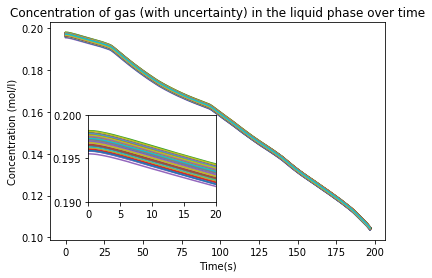

In [10]:
fig,ax=plt.subplots(figsize=[6,4])
axins=inset_axes(ax,width='38%', height = '40%',loc=3,borderpad=3.8)
ax.plot(time,Cl(q_rand,lv_rand))
ax.set_title('Concentration of gas (with uncertainty) in the liquid phase over time')
ax.set_xlabel('Time(s)')
ax.set_ylabel('Concentration (mol/l)')
axins.plot(time,Cl(q_rand,lv_rand))
axins.set_ylim((0.19,0.2))
axins.set_xlim((0,20))
plt.show()

\begin{equation}
\ln\frac{C_S-C_O}{C_S-C_L}=K_La*t
\end{equation}

In [11]:
def Kla(q,L):
    V = q*t
    TV = np.cumsum(V,axis = 0)
    Co = P*Vo/R/T/L
    Cl = P*(Vo-TV)/R/T/L
    y = np.log((Cs-Co)/(Cs-Cl))
    slope, intercept = np.polyfit(time,y,1)
    return slope

Step 4 : Display results 

In [12]:
Kla = Kla(q_rand,lv_rand) #use the randomized data as input

In [13]:
print("Kla:",np.mean(Kla))
print("Error:",np.std(Kla))  #error in Kla as a result of flow rate error of 0.01 and liquid volume error of 0.001

Kla: 0.0035516020628327386
Error: 5.08368355119112e-06


In [14]:
df_Kla = pd.DataFrame(Kla) #convert to dataframe 

In [15]:
df_Kla.describe() #show statistics

,0
count,1000.000000
mean,0.003552
std,0.000005
min,0.003536
25%,0.003548
50%,0.003552
75%,0.003555
max,0.003567


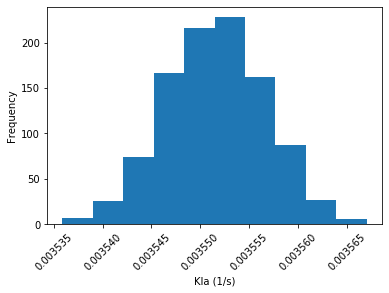

In [16]:
fig, ax = plt.subplots(figsize =(6, 4))
ax.hist(Kla)
ax.set_ylabel("Frequency")
ax.set_xlabel("Kla (1/s)")
plt.xticks(rotation=45)
plt.show()

Method 2: Calculus Based Approach

\begin{equation}
\frac{\partial f}{\partial v_j}\approx\ \frac{f(v_1, v_2,...,v_j + \Delta v_j,...v_n)-f(v_1, v_2,...,v_j - \Delta v_j,...v_n)}{2\Delta v_j}
\end{equation}

using $\sigma_j$ as $\Delta v_j$, the equation becomes:
\begin{equation}
\sigma_y^2 = \sum_{j=1}^{n}\left[\frac{f(v_1, v_2,...,v_j + \sigma_j,...,v_n)-f(v_1, v_2,...,v_j - \sigma_j,...,v_n)}{2\sigma_j} \right]^2 \sigma_j^2
\end{equation}

\begin{equation}
\sigma_y^2 = \sum_{j=1}^{n}\left[\frac{f(v_1, v_2,...,v_j + \sigma_j,...,v_n)-f(v_1, v_2,...,v_j - \sigma_j,...,v_n)}{2} \right]^2 
\end{equation}

step 1: Define model

In [17]:
q2 = np.asarray(df['Flow rate(ln/min)'],dtype='float') #reload flow rate data
lv2 = 0.53

In [18]:
def Kla2(q,L):
    V = q*t
    TV = np.cumsum(V,axis = 0)
    Co = P*Vo/R/T/L
    Cl = P*(Vo-TV)/R/T/L
    y = np.log((Cs-Co)/(Cs-Cl))
    slope, intercept = np.polyfit(time,y,1)
    return slope

Step 2: Applying Calculus approach equation:

In [19]:
a = Kla2(q2,lv2) 
b = Kla2(q2+f_sig,lv2) #Kla value when flow rate error is added to flow rate
c = Kla2(q2-f_sig,lv2) #Kla value when flow rate error is taken from the flow rate
d = Kla2(q2,lv2+lv_sig) #Kla value when liquid volume error is added to liquid volume
e = Kla2(q2,lv2-lv_sig) #Kla value when liquid volume error is taken from the liquid volume

\begin{equation}
\sigma_y^2 = \sum_{j=1}^{n}\left[\frac{f(v_1, v_2,...,v_j + \sigma_j,...,v_n)-f(v_1, v_2,...,v_j - \sigma_j,...,v_n)}{2} \right]^2 
\end{equation}

In [20]:
f_var = (0.5*(b-c))**2
lv_var = (0.5*(d-e))**2
T_var = f_var+lv_var

In [21]:
kla_std = np.sqrt(T_var)

In [22]:
print("Calculus Approach Kla =", a)
print("Monte Carlo approach Kla =", np.mean(Kla))

print("Calculus Approach Final Error =", kla_std)
print("Monte Carlo Approach Final Error =", np.std(Kla))

Calculus Approach Kla = 0.003551273513885442
Monte Carlo approach Kla = 0.0035516020628327386
Calculus Approach Final Error = 0.00014833115135173749
Monte Carlo Approach Final Error = 5.08368355119112e-06


In [23]:
fc_fl = f_var/T_var #fractional contribution of flow rate uncertainty to the total error
fc_LVs = lv_var/T_var #fractional contribution of the error in liquid volume  to the final uncertainty
print(fc_fl,fc_LVs)

0.9999608186703427 3.9181329657329385e-05


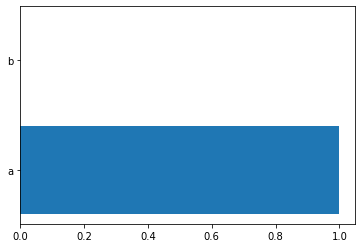

In [24]:
xbar=['a','b',]
ybar=[fc_fl, fc_LVs]

fig,ax=plt.subplots()
ax.barh(xbar,ybar)
plt.show() #most of the error in the mass transfer coefficient was due to error from the flow rate

In [25]:
#worst error assuming all the errors are fully correlated
f_dev = np.sqrt(f_var)
lv_dev = np.sqrt (lv_var)
w_err = f_dev + lv_dev #adding standard deviation due to  flow rate and liquid volume 
print(w_err)

0.00014925672413378197


## Comparison with using uncertainties library on python

https://pythonhosted.org/uncertainties/

In [26]:
import uncertainties as unc  
import uncertainties.unumpy as unumpy 

In [27]:
#read the data 
df2 = pd.read_csv('ErrorPropagation.csv')

In [28]:
#convert to arrays
tdat = np.asarray(df2['Time'],dtype='float')
qdat = np.asarray(df2['Flow rate(ln/min)'],dtype='float')

In [29]:
n = 1
sig_q = 0.01
sig_l = 0.001
liq_vol = [0.53]

In [30]:
#generate random errors
err_q = np.random.normal(0,sig_q,(n,len(qdat))) #random numbers generated around zero
err_l = np.random.normal(0,sig_l,n)
err_q = np.abs(err_q)
err_l = np.abs(err_l)

In [31]:
#check output
print(err_l.shape)
print(err_q.shape)

(1,)
(1, 985)


In [32]:
#add random error to flow rate
qdat2=unumpy.uarray(qdat, err_q ) 
qdat2=qdat2.reshape(985,n)

In [33]:
print(qdat2.shape)

(985, 1)


In [34]:
#add random error to liquid volume
liq_vol2=unumpy.uarray(liq_vol, err_l )
print(liq_vol2.shape)

(1,)


In [35]:
def Kla3(q,l):
    V = q*t
    TV = np.cumsum(V,axis = 0)
    Co = P*Vo/R/T/l
    Cl = P*(Vo-TV)/R/T/l
    y = unumpy.log((Cs-Co)/(Cs-Cl)) #use unumpy instead of numpy
    return (y[900]-y[300])/(tdat[900]-tdat[300]) #no built in function for polyfit on uncertainties library

In [36]:
print(Kla3(qdat2,liq_vol2))
print(np.mean(Kla), np.std(Kla))

[0.0038516280425065236+/-5.9732120443978276e-06]
0.0035516020628327386 5.08368355119112e-06


## Conclusion: 
- Huge difference in the result of the monte carlo method and the numerical approach. Numerical approach may only be accurate for very simple model (e.g x + y)
- Monte Carlo method is known to be most accurate error propagation technique.
- The uncertainties library uses the monte carlo approach; the results are just displayed differently.